#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 10

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
    V_rho=np.zeros(Irho_.shape)
    np.fill_diagonal(V_rho, vessel_inertia)
    cum_m=0
    cum_i=0
    fin_123=[]
    for i in range(node_N-1,-1,-1):
        cum_m+=Ws[i]*cum_d_inv[i]**2
        cum_i+=Irho_
        fin_123.append(V_rho+cum_m+cum_i)
    return np.array(fin_123[::-1])

In [16]:
lll = [225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 227.30729728986748]

In [17]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [18]:
cum_d_inv

[11081.714702627025,
 10856.149520865329,
 10630.582859614218,
 10405.013239374575,
 10179.439180627875,
 9953.859203826478,
 9728.271829383932,
 9502.675577665259,
 9277.068968977255,
 9051.45052355879,
 8825.818761571089,
 8600.17220308804,
 8374.509368086476,
 8148.828776436474,
 7923.128947891645,
 7697.408402079425,
 7471.665658491363,
 7245.899236473414,
 7020.107655216226,
 6794.289433745427,
 6568.443090911911,
 6342.567145382121,
 6116.660115628343,
 5890.720519918971,
 5664.7468763088045,
 5438.737702629322,
 5212.691516478956,
 4986.606835213379,
 4760.482175935768,
 4534.316055487086,
 4308.106990436352,
 4081.8534970709093,
 3855.554091386696,
 3629.207289078509,
 3402.8116055302708,
 3176.365555805292,
 2949.867654636529,
 2723.3164164168443,
 2496.710355189261,
 2270.047984637216,
 2043.3278180748155,
 1816.5483684370797,
 1589.7081482701883,
 1362.8056697217255,
 1135.839444530927,
 908.8079840189032,
 681.7097990788966,
 454.54340016649235,
 227.30729728986748,
 10]

In [19]:
Ws = np.array(mi)*9.81

In [20]:
Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [21]:
# Irho+=vessel_inertia

In [22]:
Irho[-1][0][0]

137909212928.43826

In [23]:
# Irho[-49][0][0]

In [24]:
Irho

array([[[1.01905603e+12, 9.58304041e+11, 9.58304041e+11],
        [9.58304041e+11, 1.01905603e+12, 9.58304041e+11],
        [9.58304041e+11, 9.58304041e+11, 1.01905603e+12]],

       [[9.03403756e+11, 8.42651768e+11, 8.42651768e+11],
        [8.42651768e+11, 9.03403756e+11, 8.42651768e+11],
        [8.42651768e+11, 8.42651768e+11, 9.03403757e+11]],

       [[7.92411706e+11, 7.31659718e+11, 7.31659718e+11],
        [7.31659718e+11, 7.92411706e+11, 7.31659718e+11],
        [7.31659718e+11, 7.31659718e+11, 7.92411707e+11]],

       [[6.85984075e+11, 6.25232088e+11, 6.25232088e+11],
        [6.25232088e+11, 6.85984075e+11, 6.25232088e+11],
        [6.25232088e+11, 6.25232088e+11, 6.85984076e+11]],

       [[5.84025088e+11, 5.23273100e+11, 5.23273100e+11],
        [5.23273100e+11, 5.84025088e+11, 5.23273100e+11],
        [5.23273100e+11, 5.23273100e+11, 5.84025088e+11]],

       [[4.86438992e+11, 4.25687004e+11, 4.25687004e+11],
        [4.25687004e+11, 4.86438992e+11, 4.25687004e+11],
    

In [25]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [26]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [27]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [28]:
E = 210e9

In [29]:
E*Ar/1e10

1.6991625880187402

In [30]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [31]:
DT=np.diag(diag_DT) # (35) in [2]

In [32]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [33]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [34]:
CT=np.diag(diag_CT)

In [35]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [36]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [37]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [38]:
rng = np.random.default_rng()

In [39]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [40]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [41]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.20586838,  0.90910567,  0.36213959],
       [-0.72273021,  0.3907481 , -0.57006751],
       [-0.65975696, -0.14437035,  0.73748082]])

In [42]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001203


In [43]:
Ret.shape

(10, 3, 3)

In [44]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [45]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [46]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000655


In [47]:
C1(dx,dy,dz,Ret)

array([[ 1.00555556, -0.40293761, -0.18631518,  0.0405773 ,  3.7308563 ,
         4.5787904 ,  0.74677894, -1.8314372 ,  0.37415868,  0.4187942 ],
       [-3.30968784, -1.0921826 ,  1.277811  , -0.03023161,  0.35951956,
        -0.616932  ,  0.06349241,  0.9492331 , -0.83587105, -1.80831218],
       [ 2.33912201,  2.13184278,  1.57548917,  0.0282343 , -0.23043774,
        -0.54415942, -1.23170895,  1.30630977, -0.1728731 , -0.50161164]])

In [48]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [49]:
fD(dx,dy,dz,DT,Ret).T

array([[  5770.91748728, -18994.41080909,  13424.300612  ],
       [ -2312.47262003,  -6268.07302106,  12234.71807584],
       [ -1069.26912622,   7333.40071844,   9041.78584238],
       [   232.87452824,   -173.50023212,    162.03761912],
       [ 21411.51092383,   2063.29498211,  -1322.49003079],
       [ 26277.83352335,  -3540.59366878,  -3122.94939661],
       [  4285.78969622,    364.38510743,  -7068.8194912 ],
       [-10510.68027348,   5447.68095562,   7496.95610035],
       [  2147.30933762,  -4797.09229923,   -992.12460662],
       [  2403.47413527, -10377.96496409,  -2878.76622118]])

In [50]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000659


In [51]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [52]:
I=np.identity(3)

In [53]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.001613


In [54]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [55]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [56]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [57]:
DR=np.diag(diag_DR) 

In [58]:
Ar

0.08091250419136858

In [59]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [60]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [61]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [62]:
def Re_b(Ret):
    return Ret

In [63]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000290


In [64]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [65]:
phi(x,y,z,Ret,None,None)

array([[ 0.4588537 , -0.09159852,  1.42219356],
       [-0.00990077, -0.36731647,  0.51376115],
       [-0.05852688, -1.02639503,  0.33323854],
       [ 0.93162425,  1.14311414,  0.17158686],
       [-0.87513938, -0.47346878, -1.09081643],
       [-0.05270746, -1.03591708,  0.89292611],
       [-0.46582868, -0.28496973,  0.88239412],
       [-0.05056377,  0.57306886,  1.2726087 ],
       [-0.7955869 , -1.11087369, -0.6839791 ],
       [-0.57240552,  0.27516532,  0.09033288]])

In [66]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000993


In [67]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [68]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [69]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000541


In [70]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [71]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000849


In [72]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.79747046, -0.51671564, -0.35097705],
       [ 0.15512774,  1.06937291, -1.06027535],
       [ 0.19870409,  2.1605021 , -1.46008404],
       [ 1.09163018,  0.35124948, -0.21108176],
       [ 0.71604712,  1.72876212,  0.97068842],
       [ 0.33307876, -0.31672789,  0.08405272],
       [-0.68175096, -0.46079915, -0.49027857],
       [-0.72496331,  2.62587291, -0.10299728],
       [-1.08083094,  2.9301965 ,  0.31234716],
       [ 0.22681154, -1.64748732, -0.43368062]])

In [73]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [74]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [75]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 1.51377694e-05,  8.81068812e-06,  1.35961998e-05,
        -9.71517562e-06, -6.17341470e-06,  1.92882390e-05,
         1.16735217e-05,  6.99532836e-06,  4.26890322e-06,
        -1.84830587e-06],
       [-9.63358664e-06, -5.23666964e-06, -3.91768163e-06,
         7.60026352e-06,  2.15696704e-06, -9.45641971e-06,
        -1.34822696e-05, -1.32318468e-05, -1.11593011e-06,
        -6.62733584e-06],
       [-5.50448549e-06, -3.57419469e-06, -9.67879006e-06,
         2.11510641e-06,  4.01657113e-06, -9.83220510e-06,
         1.80851443e-06,  6.23637855e-06, -3.15305848e-06,
         8.47567867e-06]])

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.003508


In [77]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [78]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [79]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [80]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [81]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-7.38194566e-07,  6.95575221e-07,  6.28167134e-08,
         4.07272332e-07,  1.14128003e-06,  1.06966373e-06,
        -1.83852253e-07, -1.08625883e-06,  6.80224581e-07,
        -9.21633235e-07],
       [-2.52322081e-07, -6.48554948e-07, -1.00113431e-06,
         1.37384511e-06,  6.53884486e-07, -3.78832419e-07,
        -9.65128799e-07,  1.51633670e-06,  5.55782261e-07,
         3.43515028e-07],
       [ 9.90518123e-07, -4.70216648e-08,  9.38317471e-07,
        -1.78111826e-06, -1.79516680e-06, -6.90833448e-07,
         1.14898142e-06, -4.30075703e-07, -1.23600820e-06,
         5.78120051e-07]])

In [82]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[ -5770.91748728,   2312.47262003,   1069.26912622,
          -232.87452824, -21411.51092383, -26277.83352335,
         -4285.78969622,  10510.68027348,  -2147.30933762,
         -2403.47413527],
       [ 18994.41080909,   6268.07302106,  -7333.40071844,
           173.50023212,  -2063.29498211,   3540.59366878,
          -364.38510743,  -5447.68095562,   4797.09229923,
         10377.96496409],
       [-13552.46515423, -12362.88261807,  -9169.95038461,
          -290.20216135,   1194.32548856,   2994.78485438,
          6940.65494897,  -7625.12064258,    863.96006439,
          2750.60167895]])

In [84]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000795


In [85]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 1.04858843e+03, -7.57215160e+03,  6.52356108e+03],
       [ 4.22411762e+03, -6.24839175e+03,  2.02426568e+03],
       [-1.05209898e+00,  2.91560731e+03, -2.91455521e+03],
       [ 7.29204479e+02, -1.47722372e+04,  1.40430313e+04],
       [ 2.32385833e+03, -9.37486179e+02, -1.38637680e+03],
       [-4.62286663e+03, -1.03579558e+04,  1.49808317e+04],
       [-6.84142240e+03, -4.85669735e+03,  1.16981334e+04],
       [-1.36602405e+03,  6.07029410e+03, -4.70426732e+03],
       [-1.85497021e+03,  4.19611129e+03, -2.34113737e+03],
       [-3.14063057e+03,  2.21220635e+01,  3.11851479e+03]])

In [86]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-8.98842561e+09, -2.46485308e+09, -1.41626361e+09],
       [-1.48325573e+08,  1.87593838e+09,  6.10006023e+09],
       [ 2.92043572e+09,  5.87758713e+06,  4.82548709e+06],
       [-1.35866489e+10,  4.56395509e+08,  1.18560072e+09],
       [ 3.94511530e+08, -9.91864674e+08,  1.33199598e+09],
       [-1.45711655e+10,  4.09680355e+08, -4.21319090e+09],
       [-8.92580861e+09,  2.77233098e+09, -4.06909827e+09],
       [ 8.50815261e+09,  3.80387298e+09,  2.43784756e+09],
       [ 3.99299934e+09,  1.65185632e+09, -2.03115743e+08],
       [ 7.61180244e+06,  3.12612345e+09, -1.45102542e+07]])

In [87]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000310


In [88]:
Re_b(Ret).shape

(10, 3, 3)

In [89]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [90]:
Irho_e(Ret,Irho)

array([[[ 5.91350487e+11,  1.80566218e+10,  1.52271554e+11],
        [ 2.71192691e+12, -1.03032218e+11,  9.28950420e+11],
        [ 1.46569903e+11, -5.13062754e+10,  8.37636235e+09]],

       [[-1.51638521e+12,  1.46799634e+12,  6.48400015e+11],
        [ 8.91017438e+11, -9.03939361e+11, -4.57494642e+11],
        [ 3.46066738e+10, -1.11225516e+11, -6.21308471e+09]],

       [[-3.80065228e+11,  6.25417217e+10, -2.89163037e+11],
        [ 1.11015040e+12, -2.13788818e+11,  6.33945235e+11],
        [ 1.48664270e+12, -3.81236338e+11,  9.10084876e+11]],

       [[ 4.11963764e+11,  1.37665954e+12, -3.62105583e+11],
        [-1.61258140e+11, -6.57359106e+11,  1.10911495e+11],
        [ 2.19911946e+11,  9.83218639e+11, -2.75101186e+11]],

       [[-4.88174847e+10,  1.29752624e+10, -9.77797039e+10],
        [ 1.51426063e+10,  3.83805148e+11,  1.45022207e+12],
        [ 4.82745683e+10,  2.10695715e+11,  5.97184299e+11]],

       [[ 3.47403402e+11,  2.71910689e+11,  2.92963800e+10],
        [ 2.94

In [91]:
startTime1 = datetime.now()
Irho_e(Ret,Irho)
print(datetime.now() - startTime1)

0:00:00.000961


In [92]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [93]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [94]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [95]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret.astype(np.float32),omega.astype(np.float32))

    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [96]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.003377


In [97]:
d_me_

array([[-2.61560027e-15, -6.75855798e-11,  3.56472088e-11],
       [-1.69535379e-16, -2.83153141e-11,  1.00864523e-10],
       [-1.23617362e-15, -9.18420787e-13,  6.35531030e-14],
       [-3.44500358e-15, -3.38944508e-11,  3.77777144e-11],
       [-3.25453420e-16, -1.32008597e-11,  2.92487241e-11],
       [-3.60948460e-15, -1.64402962e-10,  1.47625307e-10],
       [-2.60343783e-15, -7.38115330e-11,  1.04255368e-10],
       [-2.52157373e-15, -9.60461520e-11,  6.21721751e-11],
       [-1.52281696e-15, -2.29179356e-11,  6.73384973e-11],
       [-2.34121223e-17, -1.43267520e-10,  1.63486079e-13]])

In [98]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [99]:
ne_(dx,dy,dz,DT,Ret)

array([[ -5770.91748728,   2312.47262003,   1069.26912622,
          -232.87452824, -21411.51092383, -26277.83352335,
         -4285.78969622,  10510.68027348,  -2147.30933762,
         -2403.47413527],
       [ 18994.41080909,   6268.07302106,  -7333.40071844,
           173.50023212,  -2063.29498211,   3540.59366878,
          -364.38510743,  -5447.68095562,   4797.09229923,
         10377.96496409],
       [-13552.46515423, -12362.88261807,  -9169.95038461,
          -290.20216135,   1194.32548856,   2994.78485438,
          6940.65494897,  -7625.12064258,    863.96006439,
          2750.60167895]])

### Static solution

In [100]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [101]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [102]:
Fx_0=82945396

In [103]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [104]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [105]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [106]:
delta_x=horizontal_length/(node_N-1)

In [107]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [108]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [109]:
M_totl

array([3159111.74893617, 3158169.98893617, 3157228.22893617,
       3156286.46893617, 3155344.70893617, 3154402.94893617,
       3153461.18893617, 3152519.42893617, 3151577.66893617,
       3150635.90893617])

In [110]:
x0,z0

([0.0,
  1228.076093829069,
  2456.152187658138,
  3684.228281487207,
  4912.304375316276,
  6140.380469145344,
  7368.456562974414,
  8596.532656803482,
  9824.608750632551,
  11052.68484446162],
 [0.0,
  8.562006453662773,
  34.24969048810247,
  77.06804644731459,
  137.02539931689972,
  214.1334063426029,
  308.40705929683963,
  419.8646873934237,
  548.5279608512992,
  694.4218951076863])

In [111]:
length_p

[1228.1059401325997,
 1228.3447192647172,
 1228.8223239514793,
 1229.5388470469697,
 1230.4944278548926,
 1231.6892521556733,
 1233.1235522425875,
 1234.7976069669726,
 1236.7117417924328]

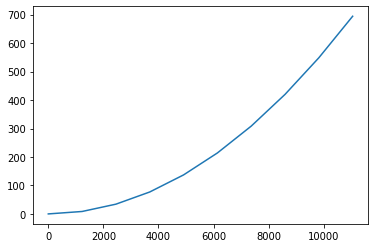

In [112]:
plt.plot(x0, z0)
plt.show()

In [113]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [114]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [115]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1] 
     
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [116]:
q0

array([0.00000000e+00, 1.22807609e+03, 2.45615219e+03, 3.68422828e+03,
       4.91230438e+03, 6.14038047e+03, 7.36845656e+03, 8.59653266e+03,
       9.82460875e+03, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.56200645e+00, 3.42496905e+01, 7.70680464e+01,
       1.37025399e+02, 2.14133406e+02, 3.08407059e+02, 4.19864687e+02,
       5.48527961e+02, 6.94421895e+02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [117]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [118]:
root

array([0.00000000e+00, 1.22807609e+03, 2.45615219e+03, 3.68422828e+03,
       4.91230438e+03, 6.14038047e+03, 7.36845656e+03, 8.59653266e+03,
       9.82460875e+03, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.56200645e+00, 3.42496905e+01, 7.70680464e+01,
       1.37025399e+02, 2.14133406e+02, 3.08407059e+02, 4.19864687e+02,
       5.48527961e+02, 6.94421895e+02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [119]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [120]:
x0

[0.0,
 1228.076093829069,
 2456.152187658138,
 3684.228281487207,
 4912.304375316276,
 6140.380469145344,
 7368.456562974414,
 8596.532656803482,
 9824.608750632551,
 11052.68484446162]

In [121]:
x0_

array([    0.        ,  1228.07609383,  2456.15218766,  3684.22828149,
        4912.30437532,  6140.38046915,  7368.45656297,  8596.5326568 ,
        9824.60875063, 11052.68484446])

In [122]:
z0

[0.0,
 8.562006453662773,
 34.24969048810247,
 77.06804644731459,
 137.02539931689972,
 214.1334063426029,
 308.40705929683963,
 419.8646873934237,
 548.5279608512992,
 694.4218951076863]

In [123]:
z0_

array([  0.        ,   8.56200645,  34.24969049,  77.06804645,
       137.02539932, 214.13340634, 308.4070593 , 419.86468739,
       548.52796085, 694.42189511])

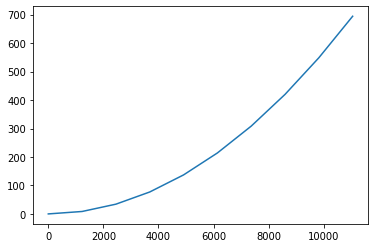

In [124]:
plt.plot(x0_, z0_)
plt.show()

In [125]:
init=1e-20
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.001*(node_N-i)*init for i in range(node_N)])
        q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([-0.001*(node_N-i)*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [126]:
q0

array([ 0.00000000e+00,  1.22807609e+03,  2.45615219e+03,  3.68422828e+03,
        4.91230438e+03,  6.14038047e+03,  7.36845656e+03,  8.59653266e+03,
        9.82460875e+03,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  8.56200645e+00,  3.42496905e+01,  7.70680464e+01,
        1.37025399e+02,  2.14133406e+02,  3.08407059e+02,  4.19864687e+02,
        5.48527961e+02,  6.94421895e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [127]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [128]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [129]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [130]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

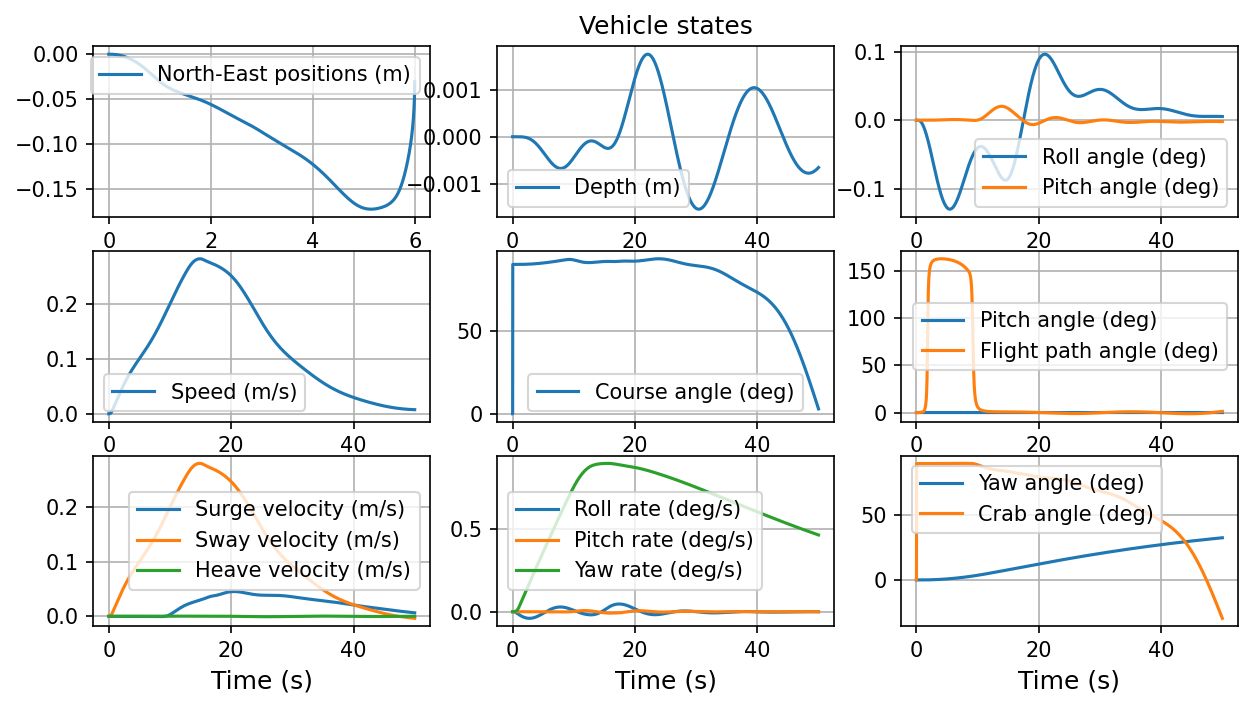

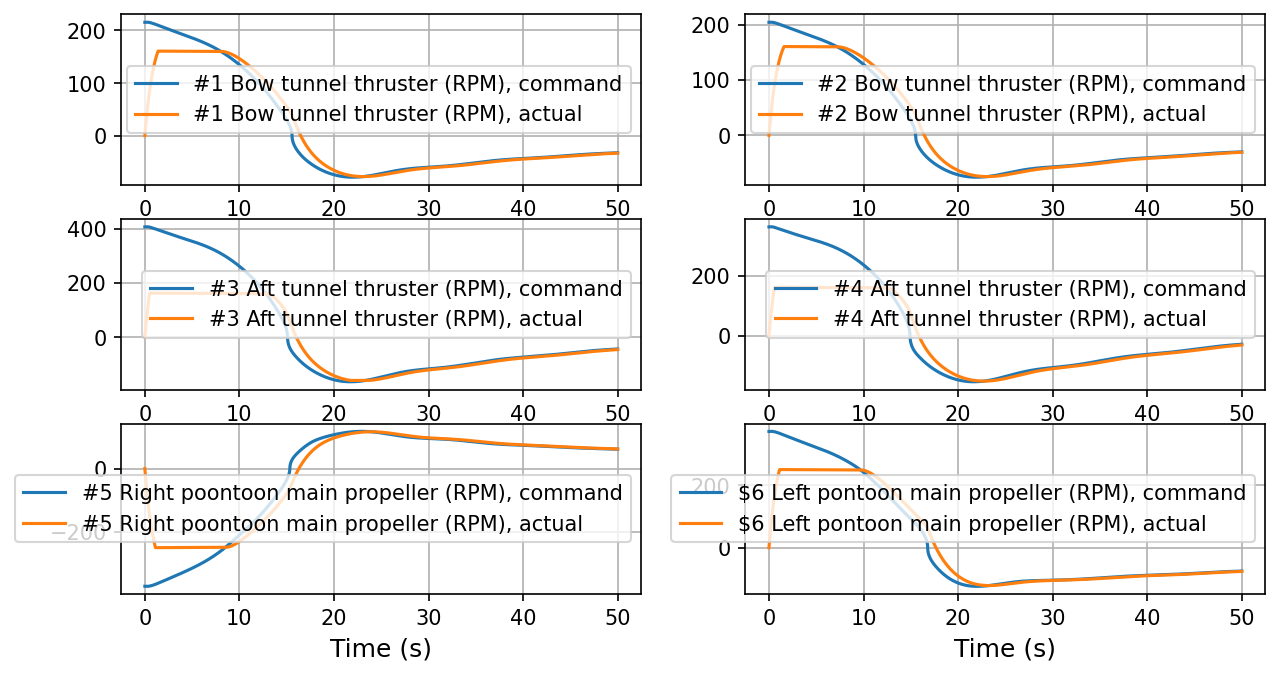

In [131]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [132]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

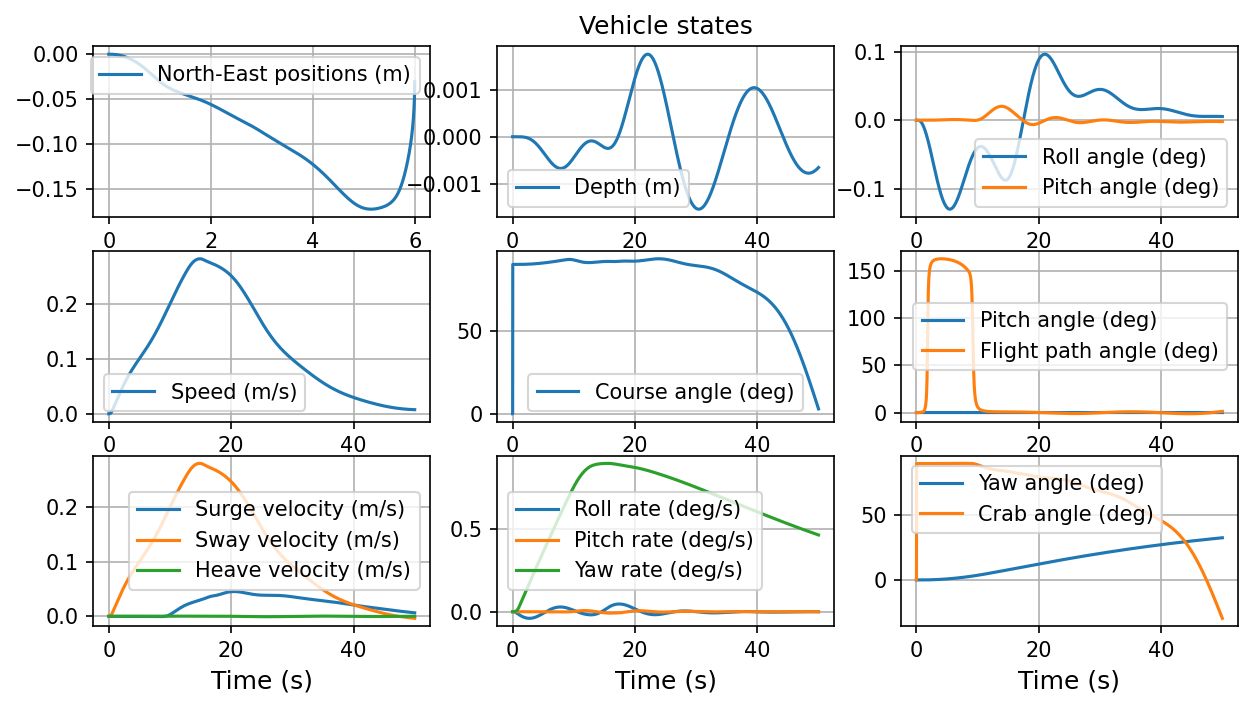

In [133]:
plotVehicleStates(simTime, simData, 3)

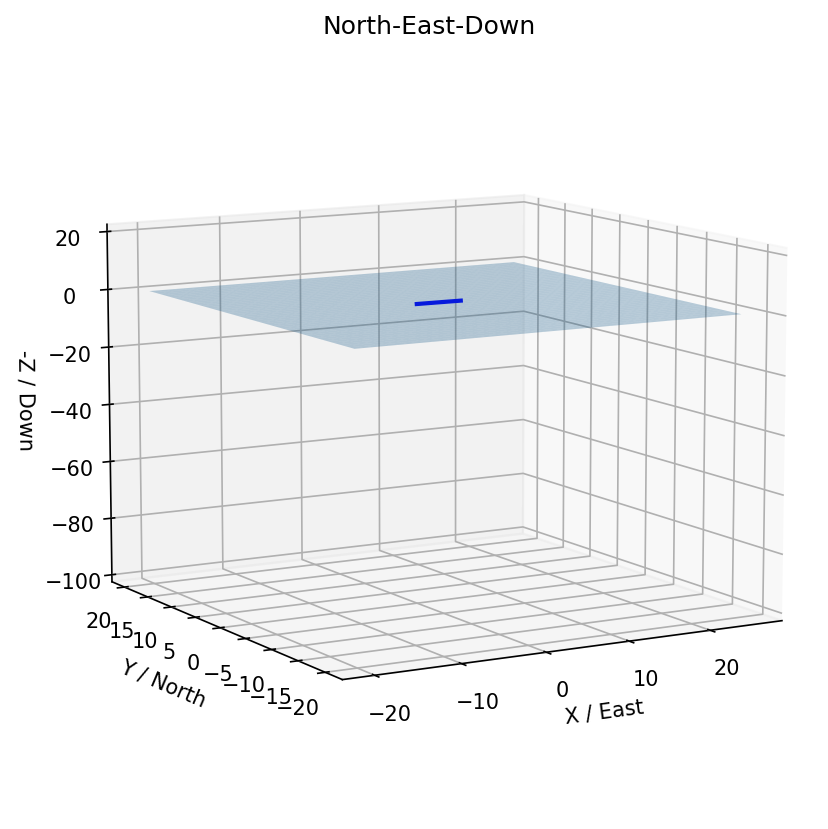

In [134]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [135]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [136]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [137]:
# Ws[0]*Ret[2]

In [138]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

### Dynamics

In [221]:
def grayscott1d(t, Q): # here
    print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1e-10
#     force_schedule=0
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(tau_force[:3])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret)
#     print(Z0)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)

    Z= (Z1 + Z2 +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
#                                              [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
                                             M_totl
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
#     print(lll)    
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1]   
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho)
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [222]:
# import scipy

In [223]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [224]:
# us=ode15s.integrate(10)

In [236]:

tspan = (0., 1)

In [ ]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0.0
0.33021591567989117
0.04866103576745198
0.07299155365117796
0.19464414306980793
0.21627127007756433
0.24330517883725988
0.24330517883725988
0.3946441430698079
0.4703136251860819
0.848661035767452
0.9159227976485844
1.0
1.0
0.2735729716837695
0.2887068681070243
0.3643763502232983
0.3778287025995248
0.3946441430698079
0.3946441430698079
0.4249119359163175
0.4400458323395723
0.5157153144558463
0.5291676668320728
0.5459831073023559
0.5459831073023559
0.4089957331009056
0.4161715281164544
0.4520505031941986
0.45842898765246426
0.4664020932252963
0.4664020932252963
0.480753683256394
0.48792947827194283
0.5238084533496871
0.5301869378079527
0.5381600433807847
0.5381600433807847
0.47681960107311333
0.48202835499702185
0.5080721246165644
0.512702128104483
0.5184896324643814
0.5184896324643814
0.5289071403121984
0.534115894236107
0.5601596638556494
0.5647896673435681
0.5705771717034664
0.5705771717034664
0.5277232019315024
0.5323399866650629
0.5554239103328654
0.5595277189849192
0.5646574797

In [ ]:
# key takeaway: one can calibrate the model by tuning bc(init) and force_schedule 

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)

# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+9] ,'-')
plt.xlabel('t')
plt.ylabel('y9')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+9] ,'-')
plt.xlabel('t')
plt.ylabel('dy9')
plt.show()

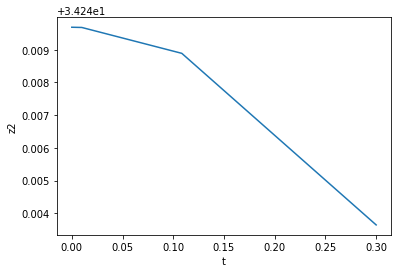

In [213]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

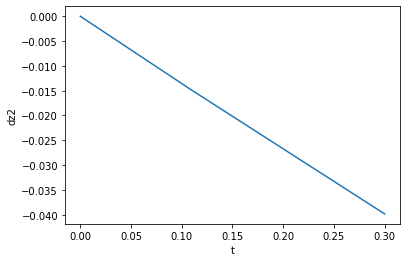

In [214]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

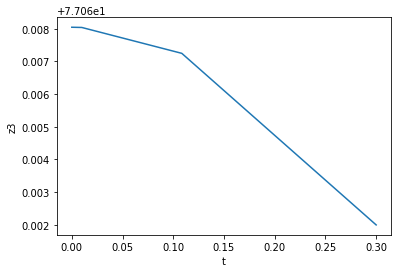

In [215]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

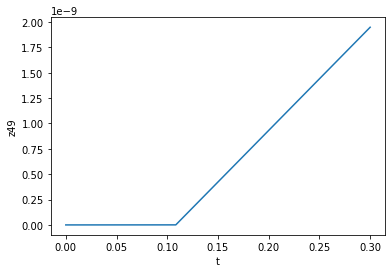

In [216]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

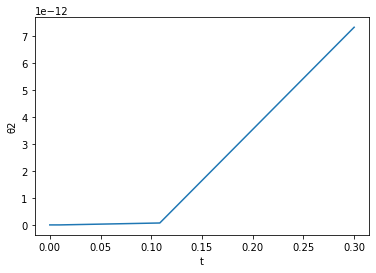

In [217]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

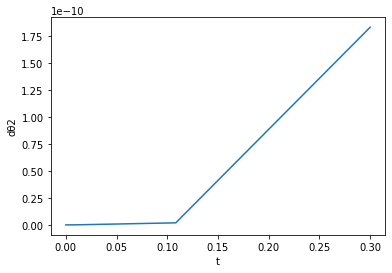

In [218]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

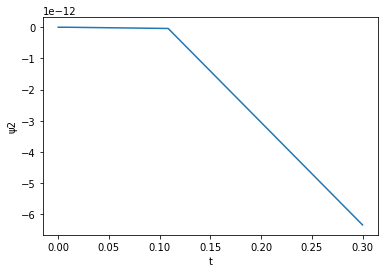

In [219]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

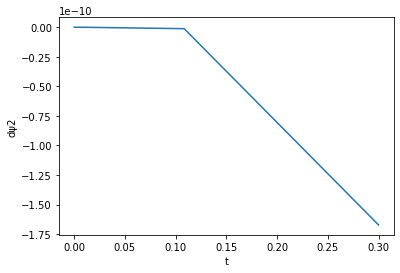

In [220]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()